In [1]:
import pathlib
import numpy as np
import pandas as pd
from scipy import sparse
import time
from sklearn.model_selection import ParameterGrid, StratifiedKFold
import xgboost as xgb
import loggingScoring as ls
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import seaborn as sns

### Initiating Logging

In [2]:
log = ls.get_logfile('5.log')
log.info('Extreme Gradient Boosting')

### Load Data

In [3]:
datapath = pathlib.Path('..') / 'Data'
data_loader = np.load(datapath / 'PreprocessedData.npz')
# data_loader = np.load('PreprocessedData_Standardized.npz')
X_train = sparse.csr_matrix((data_loader['X_train_data'],
                             data_loader['X_train_indices'],
                             data_loader['X_train_indptr']),
                            shape = data_loader['X_train_shape'])
y_train = data_loader['y_train']
X_test = sparse.csr_matrix((data_loader['X_test_data'],
                            data_loader['X_test_indices'],
                            data_loader['X_test_indptr']),
                           shape = data_loader['X_test_shape'])
y_test = data_loader['y_test']

### Model

In [4]:
default_params = xgb.XGBClassifier().get_params()
print('Default Parameters of XGBoost :\n{}'.format(default_params))

Default Parameters of XGBoost :
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


Fit time: 17.318 s / Predict time: 0.017 s ---- Precision: 0.933 / Recall: 0.936 / Accuracy: 0.937

Classification Report :

              precision    recall  f1-score   support

        Real       0.94      0.94      0.94      3187
        Fake       0.93      0.94      0.93      2936

    accuracy                           0.94      6123
   macro avg       0.94      0.94      0.94      6123
weighted avg       0.94      0.94      0.94      6123

ROC AUC Score : 0.9370768423149564


Confusion Matrix :



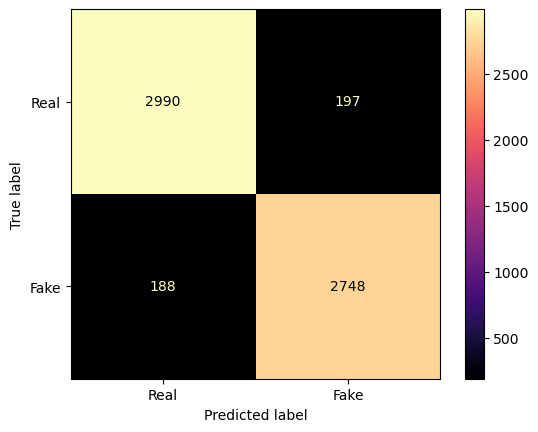

In [5]:
xgbc = xgb.XGBClassifier(use_label_encoder = False, random_state = 76)

start = time.time()
xgbc_model = xgbc.fit(X_train, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = xgbc_model.predict(X_test)
end = time.time()
pred_time = (end - start)

ls.test_results(y_test, y_pred, fit_time, pred_time)

In [6]:
new_params = xgbc_model.get_params()
del new_params['random_state'], default_params['random_state']
# since we are manually setting random_state, removing that from comparison
if (default_params == new_params):
    print('No change observed in the Default XGB Classifier',\
                                    'parameters after fitting the data.')
else:
    print('Default XGB Classifier changed following parameters after fitting :')
    for key, value in default_params.items():
        if(value != new_params[key]):
            print('{} : {}'.format(key, new_params[key]))

Default XGB Classifier changed following parameters after fitting :
missing : nan


Looks like the mismatch is just due to nan, can be ignored.

Again, The default classifier results are not very exciting (better than default Gradient Boosting scores though). Let's move on to Hyperparameter tuning.

### Hyperparameter Tuning
This is first time I am using XGBoost with a real dataset, excited and nervous at the same time. Going to follow a slightly different approach for hyperparameter tuning of XGB classifier - this is going to be specific to XGB, and tweaked towards getting fast performance out of it.
1) I am not using the sklearn version of XGB, but the native Python version - since it's supposed to be faster.
2) Although, XGB can handle sparse matrices (as already demonstrated) - XGB performs much better ("optimized for both memory efficiency and training speed" - from the [docs](https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.core)) with it's internal data structure DMatrix (or Data Matrix). They specifically handle sparse data as well (yay). I'm converting both Train and Test sets to DMatrix, and henceforth will be using them in this notebook.
3) I'm going to use XGB's own cross validation function for speed. I will still be using sklearn's StratifiedKFold, but for parameter search I will use Bayesian Optimization (as I have been doing for past few notebooks) since being a novice I want to search a lot of hyperparametrs in a reasonably wide range.
4) One of the issues is going to be the scoring metric - xgb doesn't have a metric that directly corresponds to accuracy that we have been using for our Hyperparameter tuning so far. The closest we have in [xgb](https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters) is the metric error ("classification error rate... calculated as #(wrong cases)/#(all cases)", so basically accuracy = 1 - error rate). I finally decided to use my own custom metric (thanks to the [docs](https://xgboost.readthedocs.io/en/stable/tutorials/custom_metric_obj.html#customized-metric-function) again) mimicking accuracy.
5) Some important exclusions : I will not be using gpu based training, or booster/sampling_method/tree_method/updater parameters - I will be using defaults values for these. I had separately tried to use gpu training (gpu_hist, with tree_method = hist and device = cuda) a few times with various parameters, results were varied - it got better accuracy (with other parameters intact, probably because gpu_hist uses sampling_method = gradient_based) once, and a few other times training got stuck altogether for minutes (cpu based training rarely took more than a minute). Given the size of my data (around 36000 samples) it doesn't make sense to train on GPU anyway. Similarly, with gblinear tree_method I had received much worse accuracy, to be honest though - I hadn't tried to optimize other hyperparameters to fit gblinear better. With tree_method = dart (and other parameters intact), I was able to achieve same accuracy, but it took much longer. I felt that these parameters were a bit advanced for my experience level and the current scope of the project, and decided to stick with cpu based training with gbtree (booster = gbtree, tree_method = auto - the default values).

In [7]:
train_dmatrix = xgb.DMatrix(data = X_train, label = y_train, enable_categorical = False)
test_dmatrix = xgb.DMatrix(data = X_test, label = None, enable_categorical = False)
# don't need dmatrix to handle any categorical features, since our dataset currently doesn't contain any
# also, not providing target in test set

#### Bayesian Optimization

In [8]:
boosting_rounds = 100
early_stopping_rounds = 7
skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 76)

def xgb_accuracy(predt: np.ndarray, dtrain: xgb.DMatrix):
    '''
        custom accuracy metric for xgb
        function inputs are the predictions and the dataset on which the prediction is made (with label) respectively
        these are as per the format required by xgb
        since I'm using native XGB (and not XGBClassifier, since only XGB has the inbuilt CV), predictions are probabilities
        I simply decided to round the probabilities to get 0, 1 predictions
        so, the decision boundary used is 0.5
        I had separately tried to experiment with this value, but didn't see a very drastic improvement
        the function returns the name of the metric (string), and the metric value - again, as per xgb requirements
    '''
    y = dtrain.get_label()
    predt = np.round(predt)
    return 'accuracy', (sum(predt == y) / len(predt))

def classifier_crossval_function(colsample_bylevel, colsample_bynode, colsample_bytree, gamma, learning_rate,\
                                 max_depth, min_child_weight, reg_alpha, reg_lambda, subsample):
    '''
        this is the function the optimizer will call.
        the inputs for this function will be provided by the optimizer.
        the inputs are basically the parameters within the range that we have provided.
        the inputs can be (and mostly are) floats, if classifier requires
        discrete (int) values - they need to be adjusted as such.
        the function should be able to modify the inputs as per the requirements of the classifier.
        then the classifer instance is instantiated with these provided parameters,
        and cross validated on training dataset.
        the return of the function is the mean score of the cross validation on training set.
        the Bayesian Optimizer will basically try to maximize this mean score.
        I will use the custom accuracy metric defined earlier as my target score.
    '''

    start = time.time()
    
    # modifying the hyperparameters to what XGB needs, and mostly rounding off to 3 decimals
    colsample_bylevel = round(colsample_bylevel, 3)
    colsample_bynode = round(colsample_bynode, 3)
    colsample_bytree = round(colsample_bytree, 3)
    gamma = round(gamma, 3)
    learning_rate = round(learning_rate, 3)
    max_depth = round(max_depth) # possible float to int, max_depth is supposed to be int
    min_child_weight = round(min_child_weight, 3)
    reg_alpha = round(reg_alpha, 3)
    reg_lambda = round(reg_lambda, 3)
    subsample = round(subsample, 3)

    log.info(f'Current Parameters : {colsample_bylevel = }, {colsample_bynode = }, {colsample_bytree = }, {gamma = }, ' +\
        f'{learning_rate = }, {max_depth = }, {min_child_weight = }, {reg_alpha = }, {reg_lambda = }, {subsample = }.')
    
    curr_param = {
        'colsample_bylevel' : colsample_bylevel,
        'colsample_bynode' : colsample_bynode,
        'colsample_bytree' : colsample_bytree,
        'gamma' : gamma,
        'learning_rate' : learning_rate,
        'max_depth' : max_depth,
        'min_child_weight' : min_child_weight,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'subsample' : subsample,
        'nthread' : 1,
        # restricting to a single thread, memory usage shot up (didn't crash) while trying to use 2 threads
        'disable_default_eval_metric' : True,
        'booster' : 'gbtree',
        'objective' : 'binary:logistic', # default for classification
        'tree_method' : 'auto' # default
    }
    
    res = xgb.cv(
        curr_param,
        train_dmatrix,
        num_boost_round = boosting_rounds,
        folds = skf,
        # metrics = {'auc'},
        custom_metric = xgb_accuracy,
        maximize = True,
        early_stopping_rounds = early_stopping_rounds,
        # callbacks=[xgb.callback.EarlyStopping(early_stopping_rounds)], this was causing issue...
        verbose_eval = False,
        seed = 76
    )

    
    eval_results = res.iloc[-1, [0, 2]].values
    # columns of res when used with metric auc : train-auc-mean, train-auc-std, test-auc-mean, test-auc-std,
    # train-accuracy-mean, train-accuracy-std, test-accuracy-mean, test-accuracy-std.
    # need mean accuracy values
    # columns of res when used with default metric disabled
    # and no other predefined metric used (custom metric accuracy still there):
    # train-accuracy-mean, train-accuracy-std, test-accuracy-mean, test-accuracy-std
    mean_train_score, mean_test_score = round(eval_results[0], 5), round(eval_results[1], 5)
    boosting_rounds_used = len(res)
    end = time.time()
    time_taken = round((end - start), 3)
    
    log.info(f'{time_taken = } s, {boosting_rounds_used = }. Mean Accuracy : Train - {mean_train_score}, Test - {mean_test_score}.')
    return mean_test_score

In [9]:
params_limit = {
    'colsample_bylevel' : (0.2, 1),
    'colsample_bynode' : (0.2, 1),
    'colsample_bytree' : (0.2, 1),
    'gamma' : (0, 10),
    'learning_rate' : (0.2, 0.9),
    'max_depth' : (4, 10),
    'min_child_weight' : (0, 7.5),
    'reg_alpha' : (0, 5),
    'reg_lambda' : (0, 5),
    'subsample' : (0.5, 1)
    # had to reduce range of max_depth - high values were causing kernel restart, looked like it was running out of memory
}
bayes_optimizer = BayesianOptimization(f = classifier_crossval_function,
                                       pbounds = params_limit,
                                       random_state = 76,
                                       verbose = 1)

In [10]:
bayes_optimizer.maximize(init_points = 50, n_iter = 250)
print(bayes_optimizer.max)

|   iter    |  target   | colsam... | colsam... | colsam... |   gamma   | learni... | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
| 4         | 0.9336    | 0.4269    | 0.9278    | 0.2899    | 0.7802    | 0.7016    | 7.134     | 7.263     | 4.992     | 4.399     | 0.9494    |
| 7         | 0.9364    | 0.7187    | 0.7544    | 0.7814    | 0.4555    | 0.5729    | 8.166     | 3.176     | 4.921     | 1.661     | 0.8999    |
| 36        | 0.9385    | 0.7425    | 0.6917    | 0.5914    | 3.232     | 0.5021    | 9.918     | 3.309     | 0.5184    | 2.032     | 0.9715    |
| 51        | 0.9403    | 1.0       | 0.2       | 1.0       | 3.846     | 0.9       | 5.131     | 1.658     | 0.0       | 0.0       | 1.0       |
| 52        | 0.9426    | 1.0       | 0.6241    | 1.0       | 0.844     | 0.7482    | 10.0      | 1.608     | 0.0       | 1.

In [12]:
# saving the results
# bo.res is a list of dictionaries, in which params is another dictionary
# attempting to flatten the structure, before converting it into a dataframe
flattened_list = []
for res in bayes_optimizer.res:
    flattened_dict = {}
    flattened_dict['colsample_bylevel'] = round(res['params']['colsample_bylevel'], 3)
    flattened_dict['colsample_bynode'] = round(res['params']['colsample_bynode'], 3)
    flattened_dict['colsample_bytree'] = round(res['params']['colsample_bytree'], 3)
    flattened_dict['gamma'] = round(res['params']['gamma'], 3)
    flattened_dict['learning_rate'] = round(res['params']['learning_rate'], 3)
    flattened_dict['max_depth'] = round(res['params']['max_depth'])
    flattened_dict['min_child_weight'] = round(res['params']['min_child_weight'], 3)
    flattened_dict['reg_alpha'] = round(res['params']['reg_alpha'], 3)
    flattened_dict['reg_lambda'] = round(res['params']['reg_lambda'], 3)
    flattened_dict['subsample'] = round(res['params']['subsample'], 3)
    flattened_dict['mean_test_score'] = res['target']
    flattened_list.append(flattened_dict)
df_results_bo = pd.DataFrame(flattened_list).sort_values('mean_test_score', ascending = False)
df_results_bo.to_csv(datapath / 'HPTuningResults' / 'XGB_Bayesian-results.csv', index = False)
df_results_bo.head()

,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,reg_alpha,reg_lambda,subsample,mean_test_score
258,1.0,0.2,0.2,0.963,0.9,10,1.106,0.0,0.891,1.0,0.94570
166,0.2,1.0,0.2,0.000,0.9,9,0.000,0.0,4.047,1.0,0.94564
201,0.2,0.2,1.0,1.099,0.9,10,0.863,0.0,0.940,1.0,0.94544
240,1.0,0.2,0.2,0.000,0.9,10,0.614,0.0,1.285,1.0,0.94541
60,1.0,0.2,0.2,0.000,0.9,8,0.646,0.0,1.411,1.0,0.94507


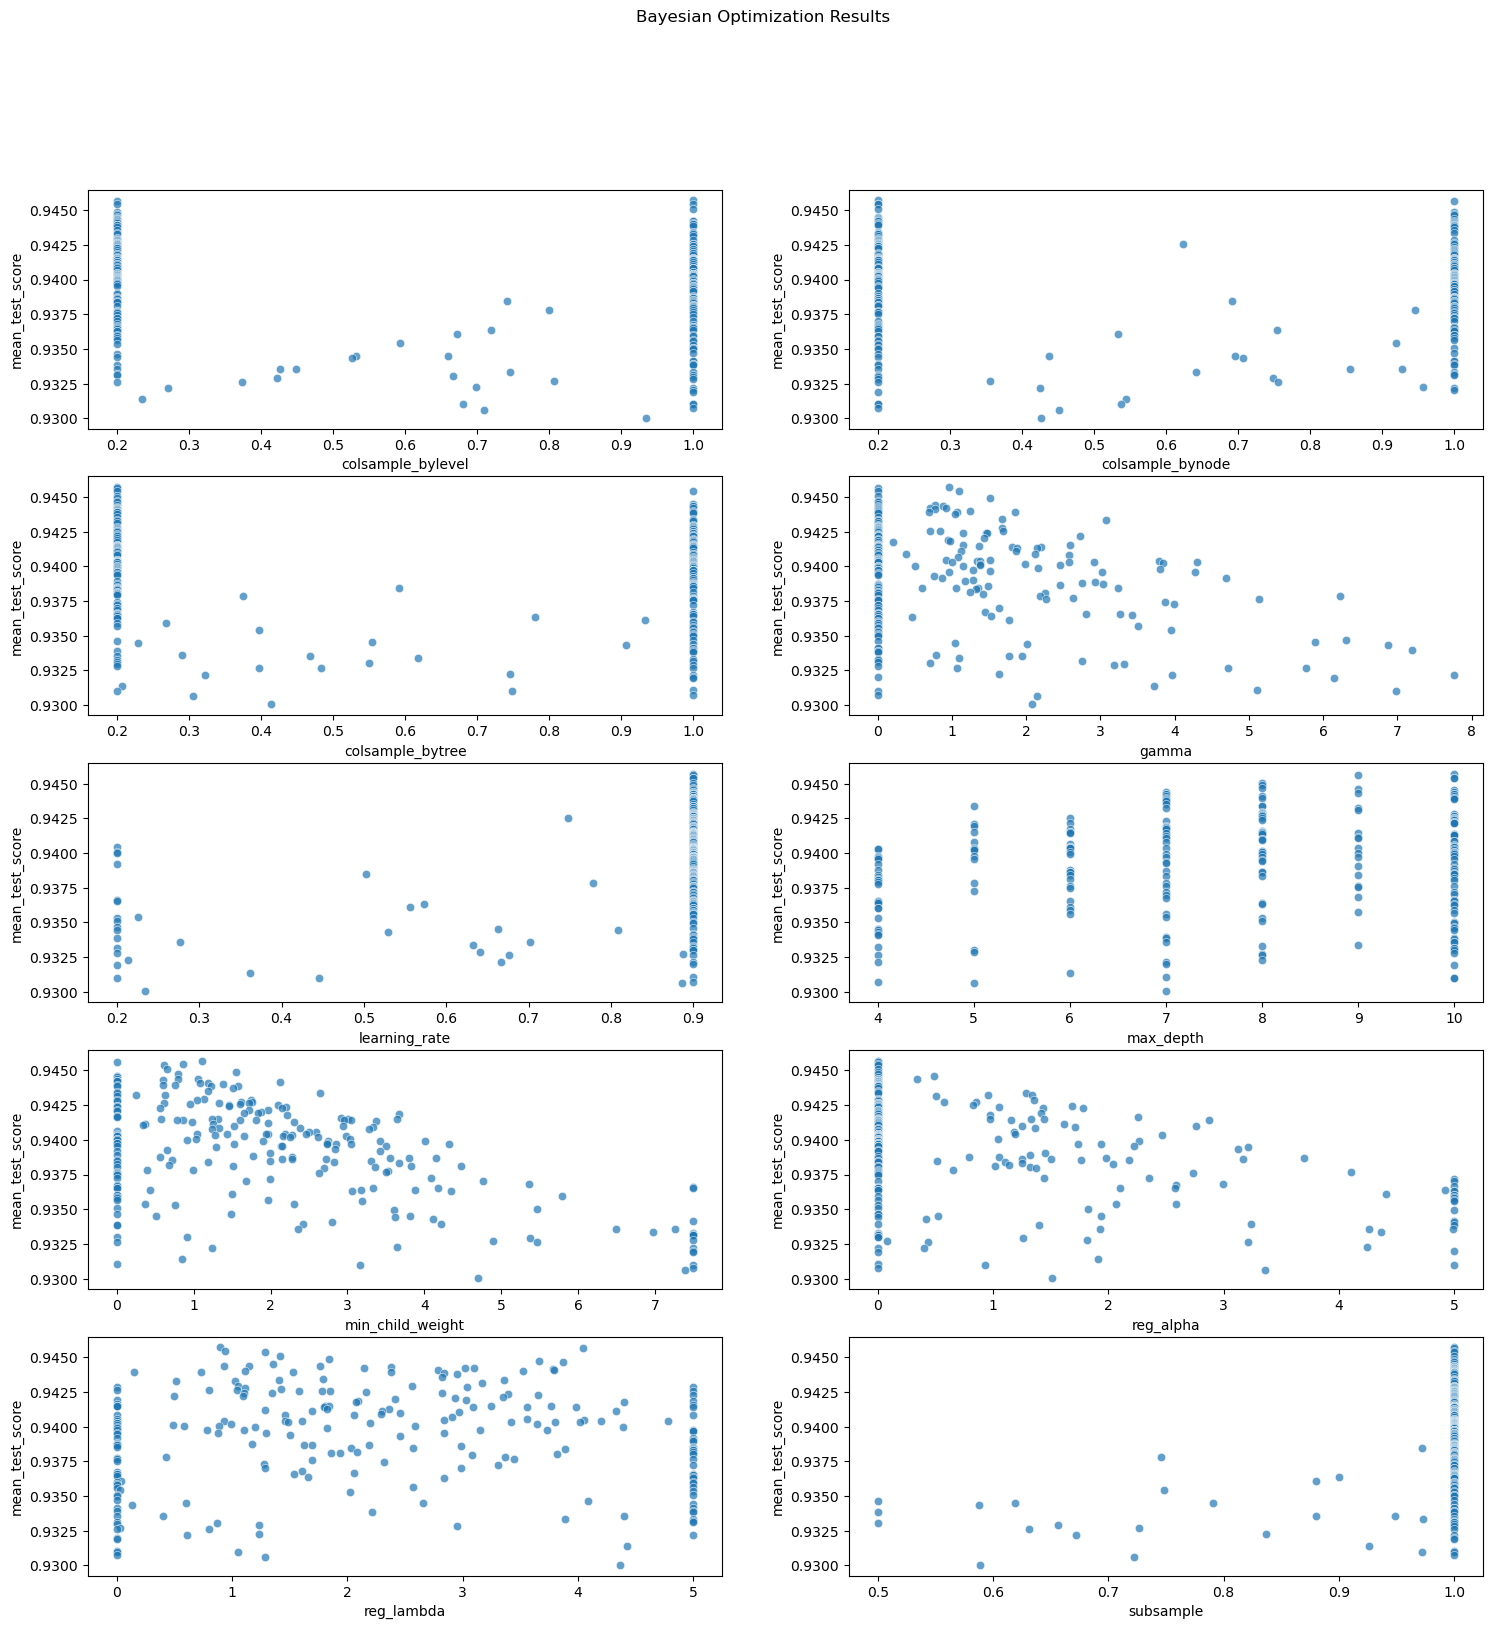

In [13]:
# visualizing the parameter space, concentrating on higher target values
df_results_bo_plot = df_results_bo[df_results_bo.mean_test_score > 0.93]
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (18, 18))

sns.scatterplot(data = df_results_bo_plot, x = 'colsample_bylevel', y = 'mean_test_score', alpha = 0.7, ax = axes[0, 0])
sns.scatterplot(data = df_results_bo_plot, x = 'colsample_bynode', y = 'mean_test_score', alpha = 0.7, ax = axes[0, 1])
sns.scatterplot(data = df_results_bo_plot, x = 'colsample_bytree', y = 'mean_test_score', alpha = 0.7, ax = axes[1, 0])
sns.scatterplot(data = df_results_bo_plot, x = 'gamma', y = 'mean_test_score', alpha = 0.7, ax = axes[1, 1])
sns.scatterplot(data = df_results_bo_plot, x = 'learning_rate', y = 'mean_test_score', alpha = 0.7, ax = axes[2, 0])
sns.scatterplot(data = df_results_bo_plot, x = 'max_depth', y = 'mean_test_score', alpha = 0.7, ax = axes[2, 1])
sns.scatterplot(data = df_results_bo_plot, x = 'min_child_weight', y = 'mean_test_score', alpha = 0.7, ax = axes[3, 0])
sns.scatterplot(data = df_results_bo_plot, x = 'reg_alpha', y = 'mean_test_score', alpha = 0.7, ax = axes[3, 1])
sns.scatterplot(data = df_results_bo_plot, x = 'reg_lambda', y = 'mean_test_score', alpha = 0.7, ax = axes[4, 0])
sns.scatterplot(data = df_results_bo_plot, x = 'subsample', y = 'mean_test_score', alpha = 0.7, ax = axes[4, 1])


fig.suptitle('Bayesian Optimization Results')
plt.show()
plt.close()

Some observations about the hyperparameters :
* For the 3 colsample parameters, looks like a combination of 1, 0.2, 0.2 works best. Since these 3 work cumulatively (in deciding how many features can be chosen from at each split), this combination translates into (35003 * 1 * 0.2 * 0.2) = 1400 features at each split.
* learning_rate = 0.9 performs best. Problem is, I had provided 0.9 as upper bound of possible learning_rate values to test. So, it is possible that the actual best value for learning_rate is actually higher than 0.9.
* Same issue with max_depth - due to memory issues on my laptop, I was forced to restrict max_depth values to 10 (upper bound). But it is clearly visible from the plot (and also makes common sense) that higher max_depth values achieve higher scores.

I have to test some other higher values for these (last) two hyperparameters, before concluding that I have got the best hyperparameters I can get (with my limited resources). However, I can't go with the Bayesian Optimization again since it can repeat the memory issues (extreme values of these two hyperparameters, combined with possible extreme value of others). I'd rather go with a crude method of changing one hyperparameter (out of learning_rate & max_depth) of the best Bayesian model each time, use the same classifier_crossval_function to get mean_test_score, and then wait for CPU & memory utilization to cool down before repeating the same steps with the next hyperparameter value. I know this does not necessarily provide the best hyperparameter within even this new range, but I have to be satisfied with this given my resource constraints.

In [14]:
new_params_to_test = {
    'learning_rate' : [0.95, 1],
    'max_depth' : [11, 12, 13, 14, 15]
}

for param, value_list in new_params_to_test.items():
    for value in value_list:
        # print(param, value)
        if (param == 'learning_rate'):
            learning_rate = value
            max_depth = 10
        else:
            learning_rate = 0.9
            max_depth = value
        mean_test_score = classifier_crossval_function(colsample_bylevel = 1.0,
                                                       colsample_bynode = 0.2,
                                                       colsample_bytree = 0.2,
                                                       gamma = 0.963,
                                                       learning_rate = learning_rate,
                                                       max_depth = max_depth,
                                                       min_child_weight = 1.106,
                                                       reg_alpha = 0.0,
                                                       reg_lambda = 0.891,
                                                       subsample = 1.0)
        print(f'Mean Test Score is {mean_test_score}, for {param} = {value}.')
        if(mean_test_score >= 0.9457):
            print('Great Score !!!')
        time.sleep(10)

Mean Test Score is 0.94262, for learning_rate = 0.95.
Mean Test Score is 0.94486, for learning_rate = 1.
Mean Test Score is 0.94166, for max_depth = 11.
Mean Test Score is 0.94527, for max_depth = 12.
Mean Test Score is 0.94616, for max_depth = 13.
Great Score !!!
Mean Test Score is 0.94564, for max_depth = 14.
Mean Test Score is 0.94354, for max_depth = 15.


Looks like max_depth = 13 (with other hyperparameters from the best Bayesian model intact) outperforms our previous best score. So, this is my best set of hyperparameters for now - this is what I will use for my best model to finally test on the test set.

One more important point to note, I had used 100 boosting rounds with 7 rounds of non-improvement as early cutoff. From the logline (given below), it can be seen that this max_depth = 13 model trained for 63 boosting rounds before overfitting - so, I'll train my final model for 63 rounds. Would have been great to use an early cutoff here as well - but I want this final model to train on the full dataset, and hence don't want to split it for an evaluation set.

From log :

"2024-04-06 01:35:27,170 INFO     kb Current Parameters : colsample_bylevel = 1.0, colsample_bynode = 0.2, colsample_bytree = 0.2, gamma = 0.963, learning_rate = 0.9, max_depth = 13, min_child_weight = 1.106, reg_alpha = 0.0, reg_lambda = 0.891, subsample = 1.0.

2024-04-06 01:35:47,731 INFO     kb time_taken = 20.561 s, ***boosting_rounds_used = 63***. Mean Accuracy : Train - 0.98514, Test - 0.94616."

### Best Model

Fit time: 6.094 s / Predict time: 0.06 s ---- Precision: 0.942 / Recall: 0.94 / Accuracy: 0.944

Classification Report :

              precision    recall  f1-score   support

        Real       0.94      0.95      0.95      3187
        Fake       0.94      0.94      0.94      2936

    accuracy                           0.94      6123
   macro avg       0.94      0.94      0.94      6123
weighted avg       0.94      0.94      0.94      6123

ROC AUC Score : 0.9435132849818191


Confusion Matrix :



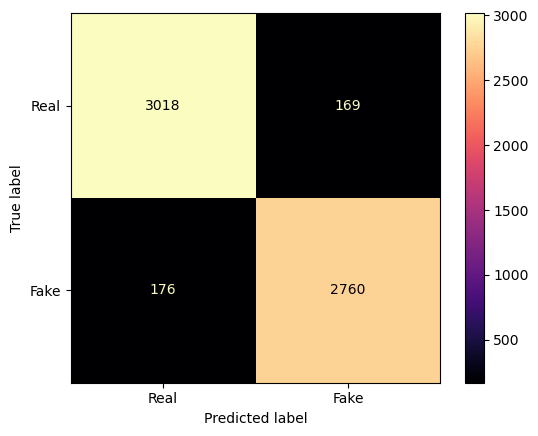

In [15]:
start = time.time()
best_params = {
    'colsample_bylevel' : 1,
    'colsample_bynode' : 0.2,
    'colsample_bytree' : 0.2,
    'gamma' : 0.963,
    'learning_rate' : 0.9,
    'max_depth' : 13,
    'min_child_weight' : 1.106,
    'reg_alpha' : 0,
    'reg_lambda' : 0.891,
    'subsample' : 1,
    'nthread' : 1,
    'disable_default_eval_metric' : True,
    'booster' : 'gbtree', # default
    'objective' : 'binary:logistic', # default for classification
    'tree_method' : 'auto' # default
}
best_xgb = xgb.train(params = best_params,
                     dtrain = train_dmatrix,
                     custom_metric = xgb_accuracy,
                     maximize = True,
                     num_boost_round = 63)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = best_xgb.predict(test_dmatrix)
end = time.time()
pred_time = (end - start)

ls.test_results(y_test, np.round(y_pred), fit_time, pred_time)

This score is little bit better than the default xgb classifier, but worse than what other classifiers (after hyperparameter tuning) had achieved. To be honest, this is most certainly not the best XGBoost model that can be trained on this dataset - as mentioned throughout this notebook, I had to test on a very small subset of hyperparameters due to various reasons. XGBoost is supposed to perform very well, and if I was unable to fine tune its hyperparameters - the bottleneck lies within my knowledge of the algorithm, and also my limited hardware resources. In any case, this is the best model I could find using xgb - but since I have better performing models (with other classifiers)) for this dataset, I would rather use them.

This has been a great learning experience though.